# 📊 Prédiction des prix des voitures 

L'objectif de ce projet est de réaliser une étude sur le marché des voitures d'occasions afin de déterminer quelles voitures ont des prix inférieurs selon les caractéristiques et de pouvoir réaliser de bonnes affaires sur le marché.

Pour ce faire, nous avons réalisé un web scraping du site https://www.autoscout24.be/fr/ nous permettant de récupérer et d'avoir une base de données en .csv pour le machine learning.

Nous avons nettoyer la base de données puis réaliser une analyse descriptive pour mieux comprendre les différentes variables.

Enfin les données ont été entrainé sur les modèles de MACHINE LEARNING afin de ressortir un modèle les voitures ayant un prix inférieur en dessous du prix prédit pour leurs caractéristiques.

Scraping
Pour le scraping, nous avons utilisé trois (3) fichiers, le fichier scraper_methods.py pour obtenir les contenus des pages HTML, puis le fichier VehicleScraper.py avec la classe VehicleScraper pour extraction des caractéristiques de voitures de chaque annonce et à la fin main.py utilisant VehicleScraper pour le scraping de plusieurs pages et enregistrer sous vehicule.csv.

Les librairies

In [2]:
import os
import pandas as pd
import numpy as np  
import seaborn as sns 
import plotly.express as px
import matplotlib.pyplot as plt

from pathlib import Path 

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score
from scipy.optimize import minimize_scalar
import joblib


sns.set_theme(style="whitegrid", palette="muted")
from matplotlib import rcParams
palette = sns.color_palette("pastel")

import warnings
warnings.filterwarnings("ignore")

**Les données**  

In [7]:
BASE_DIR = Path().resolve()
DATA_DIR = BASE_DIR / 'Donnees'

#print(f"BASE_DIR: {BASE_DIR}")
#print(f"DATA_DIR: {DATA_DIR}")


df = pd.read_csv(DATA_DIR / 'vehicules.csv')
df.head(4)

,Modèle,Prix,Transmission,Version,Kilométrage,Carburant,Puissance,Évaluations,Vendeur,Nom de la Voiture,Date
0,audi,€ 74 999,Boîte automatique,55 TFSI Quattro Tiptronic S-Line INDIVIDUAL!,34 000 km,Essence,250 kW (340 CH),121,Kristof D'herde • BE-9300 Aalst,Audi Q855 TFSI Quattro Tiptronic S-Line INDIVI...,01/2021
1,audi,€ 118 900,Boîte automatique,60 Hybride 49 CO2 BlackPack B&O 23' Leather,10 km,Electrique/Essence,340 kW (462 CH),107,Frederik Rik Maxime Jorn Hendrik • BE-8710 Wie...,Audi Q860 Hybride 49 CO2 BlackPack B&O 23' Lea...,01/2024
2,audi,€ 118 900,Boîte automatique,60 Hybr 49gr Sline BlackPack B&O Leather 23',10 km,Electrique/Essence,340 kW (462 CH),107,Frederik Rik Maxime Jorn Hendrik • BE-8710 Wie...,Audi Q860 Hybr 49gr Sline BlackPack B&O Leathe...,01/2024
3,audi,€ 59 995,Boîte automatique,50 TDi S-Line Quattro Tiptronic,95 702 km,Diesel,210 kW (286 CH),75,Mhr Jannick Lazoore • BE-8620 Nieuwpoort,Audi Q850 TDi S-Line Quattro Tiptronic,04/2019


**Nettoyage et traitement des données**

In [8]:
from cleaning_data.cleaning import nettoie 

df = nettoie(df)
df.head(4)

,modèle,prix,transmission,kilométrage,carburant,puissance,évaluations
0,audi,74999.0,Boîte automatique,34000.0,Essence,340.0,121.0
1,audi,118900.0,Boîte automatique,10.0,Electrique/Essence,462.0,107.0
2,audi,118900.0,Boîte automatique,10.0,Electrique/Essence,462.0,107.0
3,audi,59995.0,Boîte automatique,95702.0,Diesel,286.0,75.0


In [9]:
print(f"la dimension de notre table  est : {df.shape}")

la dimension de notre table  est : (2670, 7)


In [ ]:
print(f"Le nombre de valeurs manquantes : {df.isnull().sum().sum()}")

**Statistiques descriptives**

In [10]:
df.describe()

,prix,kilométrage,puissance,évaluations
count,2670.000000,2670.000000,2670.000000,2670.000000
mean,96578.187266,53196.666667,352.940075,71.760300
std,110014.952759,44613.449888,222.026120,101.638555
min,3900.000000,0.000000,69.000000,0.000000
25%,22000.000000,14500.000000,140.000000,9.000000
50%,54950.000000,44467.000000,286.000000,38.000000
75%,119950.000000,89088.000000,581.000000,93.000000
max,749995.000000,222222.000000,850.000000,671.000000


Variable	| Observations
prix	    | Moyenne ≈ 96 578€, max très élevé à 749 995€, présence de valeurs extrêmes, distribution probablement très asymétrique (positive).
kilométrage	| Large plage (0 à 222k km), médiane ≈ 44k, données probablement asymétriques aussi.
puissance	| Varie de 69 à 850 chevaux, ça va de citadine à supercar.
évaluations	| Distribution fortement déséquilibrée, médiane à 38 mais max à 671 ! Beaucoup de véhicules avec peu d’évaluations.

L'analyse exploratoire complète des données dans https://github.com/nazif96/Car-price/blob/main/Notebooks/EDA.ipynb.

## Machine Learning 

**Preprocessing des données**

In [11]:
# les données 
df = pd.read_csv(DATA_DIR / 'vehicules.csv')
df.head(4) 

,Modèle,Prix,Transmission,Version,Kilométrage,Carburant,Puissance,Évaluations,Vendeur,Nom de la Voiture,Date
0,audi,€ 74 999,Boîte automatique,55 TFSI Quattro Tiptronic S-Line INDIVIDUAL!,34 000 km,Essence,250 kW (340 CH),121,Kristof D'herde • BE-9300 Aalst,Audi Q855 TFSI Quattro Tiptronic S-Line INDIVI...,01/2021
1,audi,€ 118 900,Boîte automatique,60 Hybride 49 CO2 BlackPack B&O 23' Leather,10 km,Electrique/Essence,340 kW (462 CH),107,Frederik Rik Maxime Jorn Hendrik • BE-8710 Wie...,Audi Q860 Hybride 49 CO2 BlackPack B&O 23' Lea...,01/2024
2,audi,€ 118 900,Boîte automatique,60 Hybr 49gr Sline BlackPack B&O Leather 23',10 km,Electrique/Essence,340 kW (462 CH),107,Frederik Rik Maxime Jorn Hendrik • BE-8710 Wie...,Audi Q860 Hybr 49gr Sline BlackPack B&O Leathe...,01/2024
3,audi,€ 59 995,Boîte automatique,50 TDi S-Line Quattro Tiptronic,95 702 km,Diesel,210 kW (286 CH),75,Mhr Jannick Lazoore • BE-8620 Nieuwpoort,Audi Q850 TDi S-Line Quattro Tiptronic,04/2019


**Traitement et nettoyage des données pour l'entrainement**

In [12]:
from cleaning_data.cleaning import clean_preprocess 

df = clean_preprocess(df)
df.head(4)

,prix,kilométrage,puissance,évaluations,modèle_Unknown,modèle_audi,modèle_bentley,modèle_ferrari,modèle_fiat,modèle_ford,modèle_lamborghini,modèle_land-rover,modèle_mercedes-benz,modèle_porsche,modèle_renault,modèle_toyota,modèle_volkswagen,carburant_Diesel,carburant_Electrique,carburant_Electrique/Diesel,carburant_Electrique/Essence,carburant_Essence,transmission_Boîte automatique,transmission_Boîte manuelle
0,74999.0,34000.0,340.0,121.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False
1,118900.0,10.0,462.0,107.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False
2,118900.0,10.0,462.0,107.0,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False
3,59995.0,95702.0,286.0,75.0,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False


dtypes: bool(20), float64(4)

**Variables numériques (4)**
- prix : float64
- kilométrage : float64
- puissance : float64
- évaluations : float64

**Variables catégorielles encodées(20)**
- Modèles (13 booléennes) :
modèle_audi, modèle_bentley, ..., modèle_volkswagen, etc.

modèle_Unknown : sûrement les véhicules où le modèle n’était pas identifié.

- Carburants (5 booléennes) :
Diesel, Essence, Electrique, ou des combinaisons (Electric/Essence, etc.)

- Transmission (2 booléennes) :
Boîte automatique / manuelle


In [13]:
print(f"la dimension de notre table  est : {df.shape}")

la dimension de notre table  est : (2670, 24)


In [14]:
print(f"Le nombre de valeurs manquantes : {df.isnull().sum().sum()}")

Le nombre de valeurs manquantes : 0


- Les données sont prête pour l'entrainement nous allons proceder au découpage des données en `train` entrainement  et `test` test.

In [20]:
X = df.drop('prix', axis=1)
y = df['prix']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (2136, 23)
y_train shape: (2136,)
X_test shape: (534, 23)
y_test shape: (534,)


- Puis nous allons passer au tuning et optimisation des paramètres des modèles 
- Récupération des meilleures paramètres de chaque modèles 
- et enfin on passe à l'entrainement de chaque modèles avec les meilleures paramètres 
- évaluation des modèles 

In [16]:
df_results = pd.read_csv("resultats_modeles.csv")
df_results

,Modèle,RMSE,MAE,R²
0,KNEIGHBORS,2555.058506,156.367041,0.999453
1,GRADIENT_BOOSTING,2555.073206,163.086793,0.999453
2,RANDOM_FOREST,2562.730116,198.515564,0.999450
3,MLP,44384.112114,26930.720673,0.835062
4,RIDGE,51911.117909,33430.086921,0.774375
5,SVR,94909.890679,65441.245308,0.245796


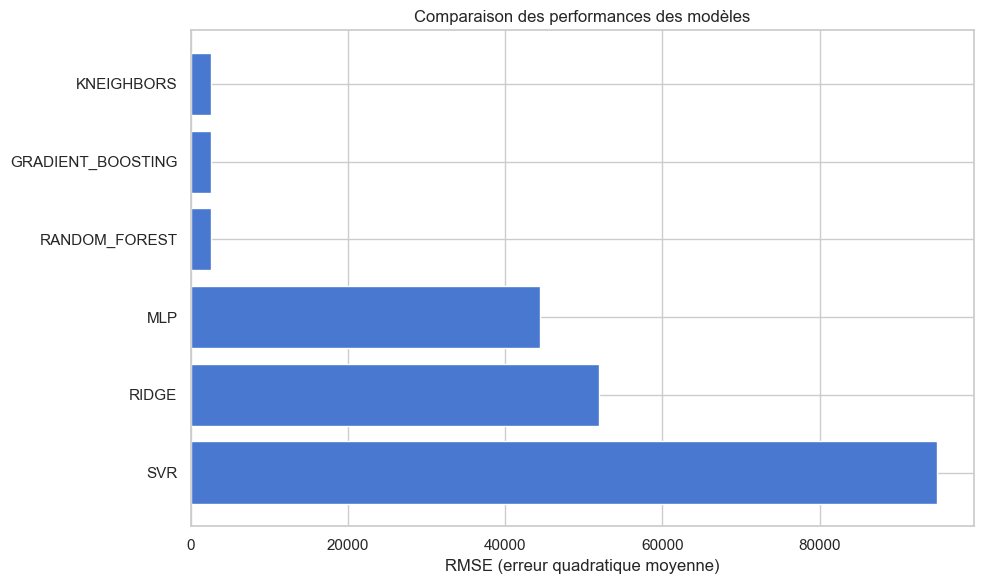

In [17]:
# 📊 Visualisation des RMSE
plt.figure(figsize=(10, 6))
plt.barh(df_results["Modèle"], df_results["RMSE"])
plt.xlabel("RMSE (erreur quadratique moyenne)")
plt.title("Comparaison des performances des modèles")
plt.gca().invert_yaxis()  # Pour que le meilleur modèle soit en haut
plt.tight_layout()
plt.show()

**interprétation** :

✅ RMSE (Root Mean Squared Error)
Mesure l'erreur moyenne pondérée.

Plus c’est petit, mieux c’est.

Ici : les 3 premiers modèles(`kneighbors, gradient_boosting, random_forest`) sont très proches (~2555) → performances très similaires.

`mlp`  Moins bon : erreur élevée malgré un R² décent 

`RIDGE` : Performances moyennes, erreurs élevées 

`SVR` : auvais modèle ici : grosse erreur et R² très faible



**KNN a la meilleure MAE, donc très précis.**

**Le meilleur modèles**

In [18]:
# chargement du meilleur modèle
modele_knn = joblib.load("meilleur_modele_knn.pkl")


**Prédiction** 

In [21]:
from machine_learning.price_prediction import analyser_prix_prediction 


voiture_exemple = {
    'modèle': 'modèle_audi',
    'kilométrage': 34000,
    'puissance': 340,
    'transmission_Boîte automatique': True
}

analyser_prix_prediction(
    modele=modele_knn,
    voiture_exemple=voiture_exemple,
    colonnes_reference=X_test.columns,
    df=df
)


💰 Prix prédit : 74999.0 €

📊 Voitures similaires trouvées : 10
📌 Prix moyen observé : 74999.0 €
🔻 Prix minimum : 74999.0 €
🔺 Prix maximum : 74999.0 €
🔸 Le prix prédit correspond exactement au prix moyen.


L'entrainement et le machine learning complète des données dans  https://github.com/nazif96/Car-price/blob/main/Notebooks/ML.ipynb 